In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from glob import glob
from scipy.integrate import quad
import symlib
import os

In [ ]:
def density_profile(base_dir, suite_name, snap, n_bins, r_min, r_max, NFW_check=True):
    """
    Measure the density profile of each host halo in a suite at a given snapshot,
    and save the profile as a pandas DataFrame (columns: halo_idx, r_scaled, rho_scaled).
    Optionally compute and return mean halo concentration and virial mass.

    Parameters
    ----------
    base_dir : str
        Root directory of the simulation suite containing all halo data.
    
    suite_name : str
        Name of the simulation suite (e.g., 'SymphonyLMC').

    snap : int
        Snapshot number to read particle data from.

    n_bins : int
        Number of logarithmic radial bins used for density profile computation.

    r_min : float
        Minimum radius (in units of R_vir) for the radial binning range.

    r_max : float
        Maximum radius (in units of R_vir) for the radial binning range.

    NFW_check : bool, optional (default: True)
        If True, compute and return mean halo concentration and virial mass
        across all host halos. Also enables tracking of halo `cvir` and `mvir`.
          
    Returns
    -------
    None
        The function writes the density profile of each halo to a CSV file.
        If `NFW_check` is True, it also prints the mean concentration and virial mass.
    """
    # Read basic simulation parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    mp = params['mp'] / h  # Particle mass [Msun]
    eps = params['eps'] / h  # Softening length [kpc]
    H0 = params["H0"]  # Hubble constant [km/s/Mpc]
    Om0 = params["Om0"]  # Matter density parameter

    # Compute background matter density rho_m = Omega_m * rho_crit
    H0_si = params["H0"] * u.km / u.s / u.Mpc
    G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
    rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
    rho_m = Om0 * rho_crit
    print(Om0)

    cvir = []
    mvir = []
    
    for halo_idx in range(n_halos):
        # Get path to the current halo
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        try:
            # Read Rockstar halo catalog
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        center = host['x'][-1]   # Halo center position
        r_vir = host['rvir']     # Virial radius [kpc]

        if NFW_check:
            # Record concentration and virial mass
            cvir_val = host['cvir']
            cvir.append(cvir_val)
            mvir_val = host['m']
            mvir.append(mvir_val)

        # Read particle snapshot
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        # Compute radial distances from halo center
        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        # Create logarithmic radial bins
        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        # Compute mass in each spherical shell
        counts, _ = np.histogram(radi_scaled, bins=bins)
        shell_volumes = (4/3) * np.pi * ((bins[1:] * r_vir)**3 - (bins[:-1] * r_vir)**3)
        mass_per_bin = counts * mp
        rho = mass_per_bin / shell_volumes  # Density [Msun/kpc^3]
        rho_scaled = rho / rho_m            # Scaled by background density

        # Save density profile to CSV
        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "rho_scaled": rho_scaled
        })

        out_path = f"{base_dir}/output/{suite_name}/density_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_profile.csv", index=False)

        print(f"[Saved] Halo {halo_idx:03d} density profile saved.")

    # Return mean concentration and mass across halos
    mean_cvir = np.mean(cvir)
    mean_mvir = np.mean(mvir)
    print(f'mean concentration: {mean_cvir}, mean mvir: {mean_mvir}')

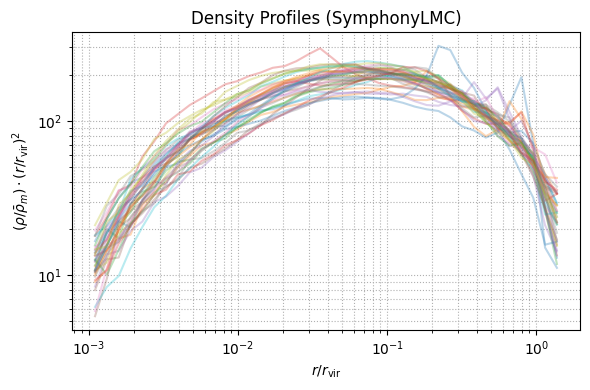

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_60685/1394362313.py:58: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.loglog(r_scaled, r_scaled**2*nfw_profile(mean_cvir,r_scaled),
/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_60685/1394362313.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.loglog(r_scaled, r_scaled**2*nfw_profile(mean_cvir,r_scaled),


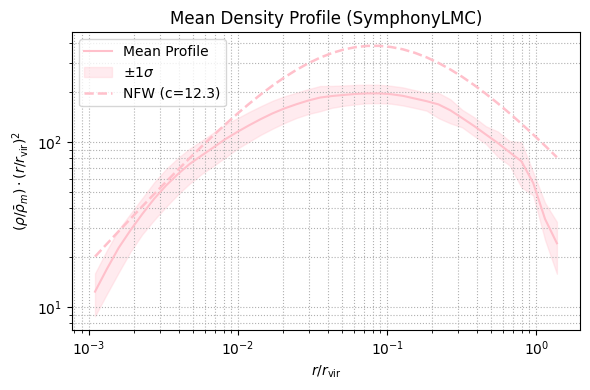

[Done] Plots saved to /Volumes/Atlas/Symphony/output/SymphonyLMC/figures/


In [ ]:
def nfw_profile(c, r_scaled):
    """
    Compute the scaled NFW density profile multiplied by r_scaled^2:
    (rho / rho_m) * (r / r_vir)^2
    """
    f_c = np.log(1 + c) - c / (1 + c)
    x = r_scaled * c
    Om0 = 0.286  # Use consistent background matter density
    delta_c = (178 * c**3) / (3 * f_c)
    rho_scaled = delta_c / (x * (1 + x)**2) / Om0
    return rho_scaled


def plot_density(base_dir, suite_name, mean_cvir):
    """
    Plot individual and mean scaled density profiles (rho * r^2 vs r) for a halo suite.
    Optionally overlay a scaled NFW profile with the given concentration.

    Parameters
    ----------
    base_dir : str
        Root directory of the simulation suite.
    
    suite_name : str
        Name of the suite whose halo profiles will be plotted.

    mean_cvir : float
        Mean concentration parameter to use for plotting the reference NFW profile.

    Returns
    -------
    None
        The function saves profile plots to the figures subdirectory.
    """
    profile_dir = f"{base_dir}/output/{suite_name}/density_profiles"
    file_list = sorted(glob(f"{profile_dir}/halo_*_profile.csv"))

    if not file_list:
        print("[Error] No profile files found.")
        return

    # -------- Load all halo profiles --------
    all_profiles = []
    for file in file_list:
        df = pd.read_csv(file)
        df["rho_r2"] = df["rho_scaled"] * df["r_scaled"]**2
        all_profiles.append(df)

    # Extract common radial binning (assumed the same for all halos)
    r_scaled = all_profiles[0]["r_scaled"].values
    rho_r2_all = np.array([df["rho_r2"].values for df in all_profiles])

    # -------- Plot 1: All halo profiles --------
    plt.figure(figsize=(6, 4))
    for rho_r2 in rho_r2_all:
        plt.loglog(r_scaled, rho_r2, alpha=0.3)
    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Density Profiles ({suite_name})")
    plt.tight_layout()
    os.makedirs(f"{base_dir}/output/{suite_name}/figures", exist_ok=True)
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/density_profiles.png", dpi=300)
    plt.show()
    plt.close()

    # -------- Plot 2: Mean + 1σ envelope + NFW --------
    mean_rho_r2 = np.mean(rho_r2_all, axis=0)
    std_rho_r2 = np.std(rho_r2_all, axis=0)

    plt.figure(figsize=(6, 4))
    plt.loglog(r_scaled, mean_rho_r2, color="pink", label="Mean Profile")
    plt.fill_between(r_scaled, mean_rho_r2 - std_rho_r2, mean_rho_r2 + std_rho_r2,
                     color="pink", alpha=0.3, label=r"$\pm1\sigma$")

    # Overlay scaled NFW profile
    nfw_rho_r2 = r_scaled**2 * nfw_profile(mean_cvir, r_scaled)
    plt.loglog(r_scaled, nfw_rho_r2,
               linestyle='--', linewidth=1.8, color='black',
               label=f"NFW (c = {mean_cvir:.1f})")

    # Optional: plot extracted profile from external file
    # ext_df = pd.read_csv('/Volumes/Atlas/Symphony/figure6_LMC.csv')
    # plt.loglog(ext_df["r/R_vir_host"], ext_df["(r/R_vir)^2 rho/rho_m"],
    #            color="black", lw=2, label="Extracted LMC Profile")

    plt.xlabel(r"$r / r_{\mathrm{vir}}$")
    plt.ylabel(r"$(\rho/\bar{\rho}_m) \cdot (r/r_{\mathrm{vir}})^2$")
    plt.grid(True, which="both", ls=":")
    plt.title(f"Mean Density Profile ({suite_name})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{base_dir}/output/{suite_name}/figures/mean_density_profile.png", dpi=300)
    plt.show()
    plt.close()

    print(f"[Done] Plots saved to {base_dir}/output/{suite_name}/figures/")

In [ ]:
def velocity_dispersion(base_dir, suite_name, snap, n_bins, r_min, r_max):
    """
    Measure the radial, tangential, and total velocity dispersion profiles, as well as the velocity anisotropy profile,
    for each host halo in a simulation suite at a given snapshot. Results are saved per halo.

    Parameters
    ----------
    base_dir : str
        Root directory of the simulation suite containing all halo data.

    suite_name : str
        Name of the simulation suite (e.g., 'SymphonyLMC').

    snap : int
        Snapshot number to read particle data from.

    n_bins : int
        Number of logarithmic radial bins used for computing dispersion profiles.

    r_min : float
        Minimum radius (in units of R_vir) for binning.

    r_max : float
        Maximum radius (in units of R_vir) for binning.

    Returns
    -------
    None
        The function writes dispersion profiles to CSV files in the velocity_profiles subdirectory.
        Each file contains the columns:
            - halo_idx
            - r_scaled
            - sigma_rad_scaled
            - sigma_tan_scaled
            - sigma_total_scaled
            - beta
    """
    
    # Read halo count and cosmological/simulation parameters
    n_halos = symlib.n_hosts(suite_name)
    params = symlib.simulation_parameters(suite_name)
    h = params['h100']
    eps = params['eps'] * h  # kpc
    H0 = params["H0"]  # km/s/Mpc

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        # Load host halo data
        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}")
            continue

        # Compute virial velocity
        center = host['x'][-1]         # Halo center [kpc]
        v_host = host['v'][-1]         # Halo bulk velocity [km/s]
        r_vir = host['rvir']           # Virial radius [kpc]
        m_vir = host['m']              # Virial mass [Msun]
        m = m_vir * u.Msun
        r = r_vir * u.kpc
        G_kpc = G.to(u.kpc * (u.km/u.s)**2 / u.Msun)
        v_vir = np.sqrt(G_kpc * m / r).to(u.km / u.s).value  # Virial velocity [km/s]

        # Load particle data
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}")
            continue

        # Positions and velocities in host frame
        x = p[0]['x']  # positions [kpc]
        v = p[0]['v']  # velocities [km/s]
        dx = x - center
        dv = v - v_host
        radi = np.linalg.norm(dx, axis=1)
        radi_scaled = radi / r_vir

        # Decompose velocities: radial vs tangential
        r_hat = dx / radi[:, None]
        v_rad = np.sum(dv * r_hat, axis=1)
        v_total = np.linalg.norm(dv, axis=1)
        v_tan = dv - v_rad[:, None] * r_hat
        v_tan_mag = np.linalg.norm(v_tan, axis=1)

        # Set up logarithmic radial bins
        bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
        bin_centers = 0.5 * (bins[1:] + bins[:-1])

        # Containers for profiles
        sigma_rad_scaled = []
        sigma_tan_scaled = []
        sigma_total_scaled = []
        beta_profile = []

        # Compute statistics in each bin
        for i in range(n_bins):
            in_bin = (radi_scaled >= bins[i]) & (radi_scaled < bins[i + 1])

            # Radial velocity dispersion
            sigma_rad = np.std(v_rad[in_bin])
            sigma_rad_scaled.append(sigma_rad / v_vir)

            # Total velocity dispersion (quadrature of components)
            sigma_x = np.std(dv[in_bin][:, 0])
            sigma_y = np.std(dv[in_bin][:, 1])
            sigma_z = np.std(dv[in_bin][:, 2])
            sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)
            sigma_total_scaled.append(sigma_total / v_vir)

            # Tangential dispersion (from subtraction)
            sigma_tan = np.sqrt(sigma_total**2 - sigma_rad**2)
            sigma_tan_scaled.append(sigma_tan / v_vir)

            # Velocity anisotropy beta = 1 - (sigma_tan^2) / (2 * sigma_rad^2)
            beta = 1 - sigma_tan**2 / (2 * sigma_rad**2)
            beta_profile.append(beta)

        # Save velocity profile for this halo
        df = pd.DataFrame({
            "halo_idx": halo_idx,
            "r_scaled": bin_centers,
            "sigma_rad_scaled": sigma_rad_scaled,
            "sigma_tan_scaled": sigma_tan_scaled,
            "sigma_total_scaled": sigma_total_scaled,
            "beta": beta_profile
        })

        out_path = f"{base_dir}/output/{suite_name}/velocity_profiles"
        os.makedirs(out_path, exist_ok=True)
        df.to_csv(f"{out_path}/halo_{halo_idx:03d}_vel_profile.csv", index=False)

        print(f"[Saved] Halo {halo_idx:03d} velocity profile saved.")


[Saved] Halo 000 velocity profile saved.
[Saved] Halo 001 velocity profile saved.
[Saved] Halo 002 velocity profile saved.
[Saved] Halo 003 velocity profile saved.
[Saved] Halo 004 velocity profile saved.
[Saved] Halo 005 velocity profile saved.
[Saved] Halo 006 velocity profile saved.
[Saved] Halo 007 velocity profile saved.
[Saved] Halo 008 velocity profile saved.
[Saved] Halo 009 velocity profile saved.
[Saved] Halo 010 velocity profile saved.
[Saved] Halo 011 velocity profile saved.
[Saved] Halo 012 velocity profile saved.
[Saved] Halo 013 velocity profile saved.
[Saved] Halo 014 velocity profile saved.
[Saved] Halo 015 velocity profile saved.
[Saved] Halo 016 velocity profile saved.
[Saved] Halo 017 velocity profile saved.
[Saved] Halo 018 velocity profile saved.
[Saved] Halo 019 velocity profile saved.
[Saved] Halo 020 velocity profile saved.
[Saved] Halo 021 velocity profile saved.
[Saved] Halo 022 velocity profile saved.
[Saved] Halo 023 velocity profile saved.
[Saved] Halo 024

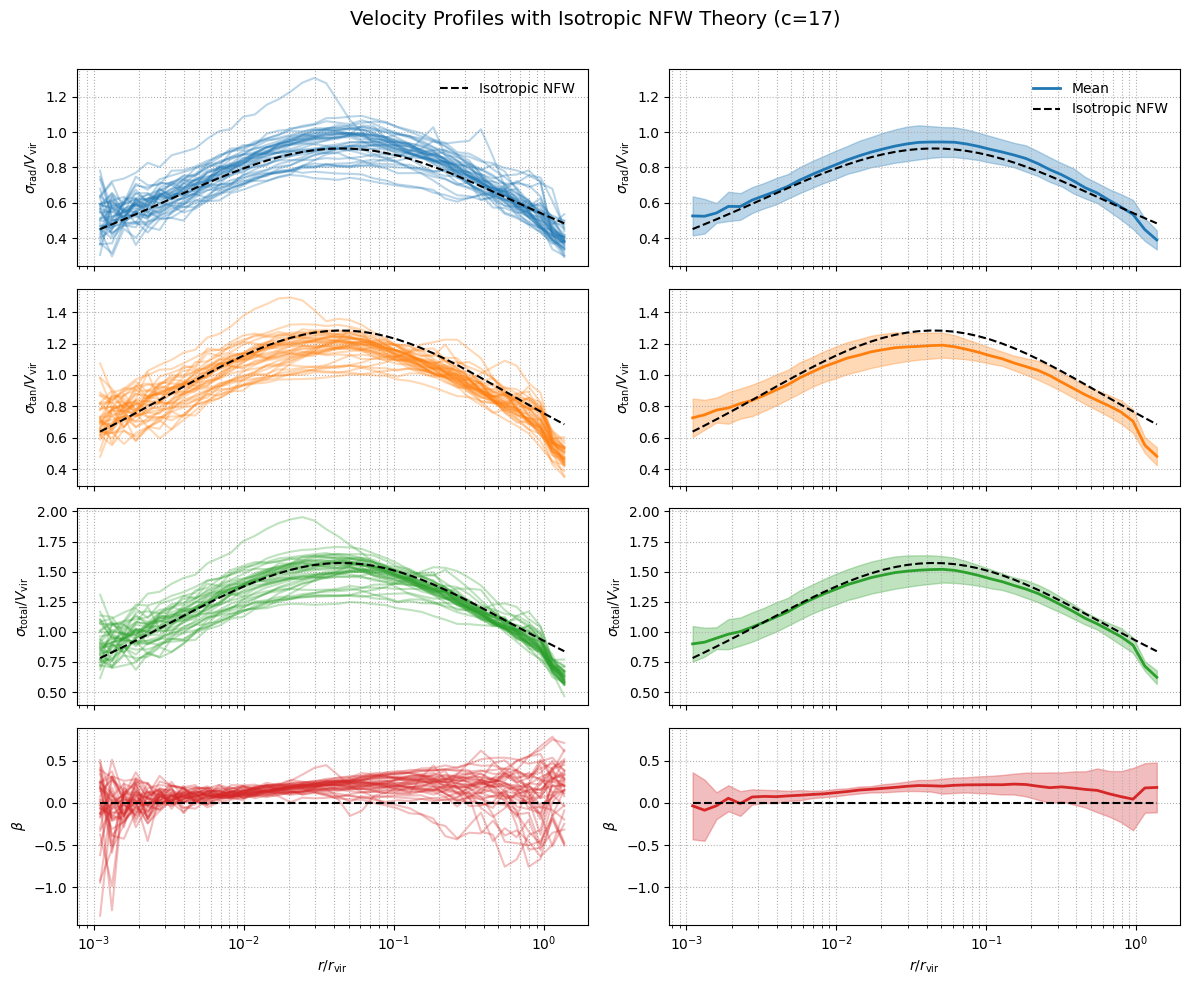

[Saved] Profiles saved with NFW comparison.


In [ ]:
def plot_velocity(base_dir, suite_name, mean_cvir):
    """
    Plot velocity dispersion (radial, tangential, total) and anisotropy (beta) profiles
    for all halos in a simulation suite. Compare them with the theoretical isotropic NFW solution.

    Parameters
    ----------
    base_dir : str
        Root directory of the simulation output.
    
    suite_name : str
        Name of the simulation suite (e.g. 'SymphonyLMC').

    mean_cvir : float
        Mean concentration of halos, used to compute isotropic NFW model predictions.

    Returns
    -------
    None
        Saves a grid plot of all dispersion and anisotropy profiles to the suite's figure directory.
    """
    # Define input/output directories
    input_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    output_dir = os.path.join(base_dir, "output", suite_name, "figures")
    os.makedirs(output_dir, exist_ok=True)

    # Collect all halo velocity profile files
    files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])
    if not files:
        print("[Error] No CSV files found for velocity profiles.")
        return

    # Load data arrays for all halos
    r = pd.read_csv(os.path.join(input_dir, files[0]))["r_scaled"].values
    sigma_rad_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_rad_scaled"].values for f in files])
    sigma_tan_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_tan_scaled"].values for f in files])
    sigma_total_all = np.array([pd.read_csv(os.path.join(input_dir, f))["sigma_total_scaled"].values for f in files])
    beta_all = np.array([pd.read_csv(os.path.join(input_dir, f))["beta"].values for f in files])

    # =============================================
    # Compute isotropic NFW velocity dispersion profiles
    # =============================================
    c = mean_cvir
    g_c = 1 / (np.log(1 + c) - c / (1 + c))

    def integrand(t):
        g_t = (1 + c * t) * np.log(1 + c * t) - c * t
        return g_t / (t**3 * (1 + c * t)**3)

    sigma_rad_nfw = np.zeros_like(r)
    for i, r_val in enumerate(r):
        if r_val <= 0:
            sigma_rad_nfw[i] = np.nan
            continue
        integral, _ = quad(integrand, r_val, np.inf)
        sigma_r2 = g_c * (1 + c * r_val)**2 * r_val * integral
        sigma_rad_nfw[i] = np.sqrt(sigma_r2)

    # For isotropic systems:
    sigma_tan_nfw = sigma_rad_nfw  # σ_tan = σ_rad
    sigma_total_nfw = np.sqrt(3) * sigma_rad_nfw
    beta_nfw = np.zeros_like(r)  # β = 0

    # =====================
    # Generate subplots
    # =====================
    fig, axes = plt.subplots(4, 2, figsize=(12, 10), sharex=True)
    titles = [r"$\sigma_{\mathrm{rad}} / V_{\mathrm{vir}}$", 
              r"$\sigma_{\mathrm{tan}} / V_{\mathrm{vir}}$",
              r"$\sigma_{\mathrm{total}} / V_{\mathrm{vir}}$",
              r"$\beta$"]
    data_arrs = [sigma_rad_all, sigma_tan_all, sigma_total_all, beta_all]
    colors = ["C0", "C1", "C2", "C3"]
    nfw_profiles = [sigma_rad_nfw, sigma_tan_nfw, sigma_total_nfw, beta_nfw]

    for i in range(4):
        y_min = np.nanmin(data_arrs[i])
        y_max = np.nanmax(data_arrs[i])
        y_pad = 0.05 * (y_max - y_min)

        # Left panel: all halo curves
        for arr in data_arrs[i]:
            axes[i, 0].plot(r, arr, color=colors[i], alpha=0.3)
        axes[i, 0].plot(r, nfw_profiles[i], 'k--', lw=1.5, label='Isotropic NFW')
        axes[i, 0].set_ylabel(titles[i])
        axes[i, 0].set_xscale("log")
        axes[i, 0].set_ylim(y_min - y_pad, y_max + y_pad)
        axes[i, 0].grid(True, which="both", linestyle=":")
        if i == 0:
            axes[i, 0].legend(loc='best', frameon=False)

        # Right panel: mean ± 1σ + theory
        mean = np.nanmean(data_arrs[i], axis=0)
        std = np.nanstd(data_arrs[i], axis=0)
        axes[i, 1].plot(r, mean, color=colors[i], lw=2, label='Mean')
        axes[i, 1].fill_between(r, mean - std, mean + std, color=colors[i], alpha=0.3)
        axes[i, 1].plot(r, nfw_profiles[i], 'k--', lw=1.5, label='Isotropic NFW')
        axes[i, 1].set_ylabel(titles[i])
        axes[i, 1].set_xscale("log")
        axes[i, 1].set_ylim(y_min - y_pad, y_max + y_pad)
        axes[i, 1].grid(True, which="both", linestyle=":")
        if i == 0:
            axes[i, 1].legend(loc='best', frameon=False)

    # X-axis labels
    axes[3, 0].set_xlabel(r"$r / r_{\mathrm{vir}}$")
    axes[3, 1].set_xlabel(r"$r / r_{\mathrm{vir}}$")

    fig.suptitle(f"Velocity Profiles with Isotropic NFW Theory (c={c})", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.savefig(os.path.join(output_dir, "velocity_profiles_with_NFW.png"))
    plt.show()
    plt.close(fig)

    print("[Saved] Profiles saved with NFW comparison.")

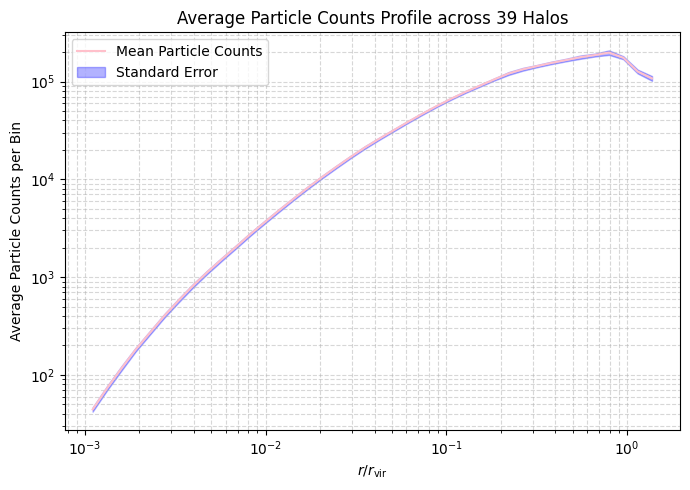

In [ ]:
def average_particle_counts_profile(base_dir, suite_name, snap, n_bins=40, r_min=0.001, r_max=1.5, plot=True):
    """
    Compute the average radial distribution of particle counts across all host halos
    in a simulation suite, normalized by the host halo's virial radius.

    Parameters
    ----------
    base_dir : str
        Root directory containing the simulation output.

    suite_name : str
        Name of the simulation suite (e.g., 'SymphonyLMC').

    snap : int
        Snapshot number to read particle data from.

    n_bins : int, optional
        Number of radial bins (logarithmically spaced). Default is 40.

    r_min : float, optional
        Minimum radius (in units of R_vir) for binning. Default is 0.001.

    r_max : float, optional
        Maximum radius (in units of R_vir) for binning. Default is 1.5.

    plot : bool, optional
        Whether to display a matplotlib plot of the mean counts profile. Default is True.

    Returns
    -------
    bin_centers : ndarray
        Midpoints of the logarithmic radial bins (scaled by R_vir).

    mean_counts : ndarray
        Mean number of particles per bin across halos.

    stderr_counts : ndarray
        Standard error of the mean particle counts per bin.
    """

    # Get total number of host halos
    n_halos = symlib.n_hosts(suite_name)
    all_counts = []

    # Define radial bin edges and centers (uniform across all halos)
    bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for halo_idx in range(n_halos):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, halo_idx)

        # Load halo center and R_vir from Rockstar catalog
        try:
            r, hist = symlib.read_rockstar(sim_dir)
            host = r[0, -1]
        except FileNotFoundError:
            print(f"[Warning] Rockstar file not found for Halo {halo_idx}, skipped.")
            continue

        center = host['x'][-1]       # Halo center [kpc]
        r_vir = host['rvir']         # Virial radius [kpc]

        # Load particle data
        part = symlib.Particles(sim_dir)
        try:
            p = part.read(snap)
        except FileNotFoundError:
            print(f"[Warning] Particle snapshot not found for Halo {halo_idx}, skipped.")
            continue

        x = p[0]['x']
        dx = x - center
        radi = np.linalg.norm(dx, axis=1)        # Distance from halo center [kpc]
        radi_scaled = radi / r_vir               # Normalize radius by R_vir

        # Bin particles by scaled radius
        counts, _ = np.histogram(radi_scaled, bins=bins)
        all_counts.append(counts)

    if len(all_counts) == 0:
        raise RuntimeError("No halo data available for particle count statistics.")

    all_counts = np.array(all_counts)            # (n_halos, n_bins)
    mean_counts = np.mean(all_counts, axis=0)    # Mean across halos
    stderr_counts = np.std(all_counts, axis=0) / np.sqrt(all_counts.shape[0])  # Standard error

    # ================
    # Optional plotting
    # ================
    if plot:
        plt.figure(figsize=(7, 5))
        plt.plot(bin_centers, mean_counts, label='Mean Particle Counts', color='pink')
        plt.fill_between(bin_centers, mean_counts - stderr_counts, mean_counts + stderr_counts,
                         color='blue', alpha=0.3, label='Standard Error')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r"$r / r_{\mathrm{vir}}$")
        plt.ylabel("Average Particle Counts per Bin")
        plt.title(f"Average Particle Counts Profile across {len(all_counts)} Halos")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return bin_centers, mean_counts, stderr_counts
